In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train_df = train_transaction.merge(train_identity, how='left', on='TransactionID')
test_df = test_transaction.merge(test_identity, how='left', on='TransactionID')

Посмотрим какой объём оперативной памяти занимают датасеты:

In [4]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время. 

Исходя из этого необходимо уменьшить занимаемый ими объём памяти. Сделаем это при помощи способа с изменением типов переменных

Напишем функцию подсчёта объема занимаемой памяти:

In [5]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Преобразуем все значения подтипов ```float``` в тип ```float```
3. Преобразуем все значения типа ```object``` в тип ```category```, но только для столбцов, в которых содержится менее ```50 %``` уникальных значений, иначе объём занимаемой памяти наоборот увеличится (согласно исследованиям)

In [6]:
def obj_to_cat(current_df_obj):
    converted_df_obj=pd.DataFrame()
    for col in current_df_obj.columns:
        num_unique_values = len(current_df_obj[col].unique())
        num_total_values = len(current_df_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_df_obj.loc[:, col] = current_df_obj[col].astype('category')
        else:
            converted_df_obj.loc[:, col] = current_df_obj[col]
    return converted_df_obj

In [7]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    # convert object
#     df_obj = df.select_dtypes(include=['object'])
#     converted_obj = obj_to_cat(df_obj)
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
#     optimized_df[converted_obj.columns] = converted_obj
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [8]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



Видим, что объём занимаемой памяти тренировочного и тестового датасетов после изменения числовых типов данных уменьшился примерно на ```35 %```

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float32(399), object(31), uint16(1), uint32(2), uint8(1)
memory usage: 1.0+ GB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: float32(399), object(31), uint16(1), uint32(2)
memory usage: 895.9+ MB


#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [11]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [12]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

Удаляем признаки, в которых более ```80 %``` пропусков:

In [13]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 80.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 74 columns.


In [14]:
missing_df

,Missing Values,% of Total Values
id_24,585793,99.2
id_25,585408,99.1
id_07,585385,99.1
id_08,585385,99.1
id_21,585381,99.1
...,...,...
V285,12,0.0
V284,12,0.0
V280,12,0.0
V279,12,0.0


In [15]:
train_df = train_df.drop(columns = missing_columns)

In [16]:
train_df.shape

(590540, 360)

In [17]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 359)

Посмотрим ещё раз на пропуски 

In [18]:
missing_values_table(train_df, 'train_df')

train_df has  360 columns.
 There are 340 columns that have missing values.


,Missing Values,% of Total Values
DeviceInfo,471874,79.9
id_13,463220,78.4
id_16,461200,78.1
V233,460110,77.9
V249,460110,77.9
...,...,...
V309,12,0.0
V310,12,0.0
V311,12,0.0
V312,12,0.0


In [19]:
missing_values_table(test_df, 'test_df')

test_df has  359 columns.
 There are 311 columns that have missing values.


,Missing Values,% of Total Values
DeviceInfo,391634,77.3
id_16,380944,75.2
V235,379963,75.0
V252,379963,75.0
V249,379963,75.0
...,...,...
V307,3,0.0
V308,3,0.0
V309,3,0.0
V310,3,0.0


In [20]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.000000,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.000000,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.000000,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.000000,H,4497,514.0,150.0,mastercard,102.0,...,144.0,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.500000,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.950001,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.000000,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Заполним пропуски тренировочного и тестового датасетов

Создадим списки числовых и категориальных признаков:

In [21]:
cat_features = train_df.select_dtypes(include=['object']).columns
num_features = [x for x in train_df.columns.values[2:] 
                if x not in cat_features]
print('len cat_features: ', len(cat_features))
print('len num_features: ', len(num_features))

len cat_features:  26
len num_features:  332


Пропуски в числовых признаках мы заполним средним по колонке

In [22]:
train_df[num_features] = train_df[num_features].fillna(
    train_df[num_features].mean())

Для категориальных признаков будем использовать ```-1.0``` в качестве символа пропуска:

In [23]:
train_df = train_df.fillna(-1)

In [24]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,362.555511,150.0,discover,142.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2987001,0,86401,29.000000,W,2755,404.000000,150.0,mastercard,102.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2987002,0,86469,59.000000,W,4663,490.000000,150.0,visa,166.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2987003,0,86499,50.000000,W,18132,567.000000,150.0,mastercard,117.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2987004,0,86506,50.000000,H,4497,514.000000,150.0,mastercard,102.0,...,144.000000,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,362.555511,150.0,visa,226.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590536,3577536,0,15811049,39.500000,W,10444,225.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590537,3577537,0,15811079,30.950001,W,12037,595.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590538,3577538,0,15811088,117.000000,W,7826,481.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1


Аналогично заполним пропуски в тестовом датасете:

In [25]:
test_df[num_features] = test_df[num_features].fillna(
    test_df[num_features].mean())

In [26]:
test_df = test_df.fillna(-1)

#### Посмотрим на распределение целевой переменной ```isFraud```

In [27]:
isFraud_count = train_df['isFraud'].value_counts()
isFraud_prct = train_df['isFraud'].value_counts()/len(train_df)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

,Count,Percent
isFraud,,
0,569877,0.96501
1,20663,0.03499


In [28]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[df[feature] != -1][feature].value_counts().plot(kind='bar',
                                        figsize=(7,5),
                                        xlabel=title,
                                        ylabel='count',
                                        edgecolor='k',
                                        color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

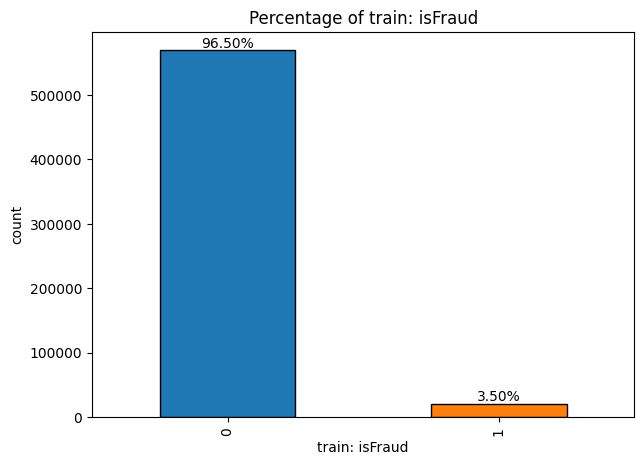

In [29]:
plot_value_counts('isFraud', 'train: isFraud', df=train_df)

Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

#### Распределение ```Card 4``` (компания карты)

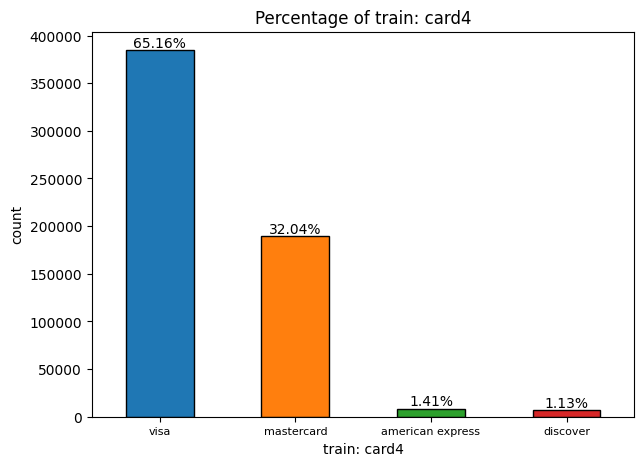

In [30]:
plot_value_counts('card4', 'train: card4', df=train_df)

Видим, что:

- ```65,16 %``` - карт компании 'visa'
- ```32,04 %``` - 'mastercard'
- ```1,41 %```  - 'american express'
- ```1,13 %```  - 'discover'

#### Распределение ```Card 6``` - тип карты

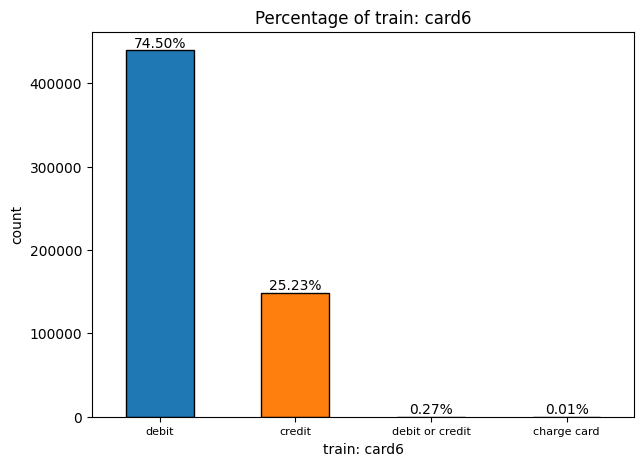

In [31]:
plot_value_counts('card6', 'train: card6', df=train_df)

Большая часть транзакций произведена дебетовыми картами - ```74,5 %```, ```25,23 %``` - кредитными картами. Транзакций с ```charge``` карт нет

#### Распределение транзакций по ```DeviceType```

DeviceType
desktop    85165
mobile     55645
Name: TransactionDT, dtype: int64


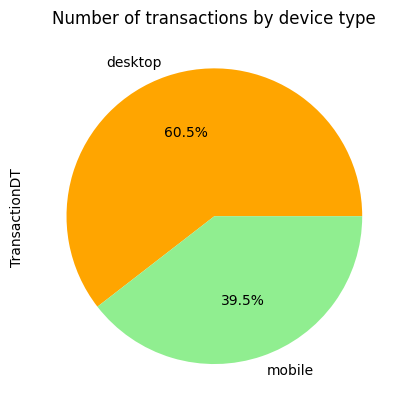

In [32]:
device_type_df = train_df[train_df['DeviceType']!=-1].groupby(by='DeviceType').TransactionDT.count()
device_type_df.plot(kind='pie', 
                    colors=['orange', 'lightgreen'],
                    autopct='%1.1f%%')
plt.title('Number of transactions by device type')
print(device_type_df)

Большинство транзакций было выполнено с компьютера - ```60.5 %```

С мобильных устройств - ```39.5 %``` транзакций

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [33]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df[df[feature]!=-1])
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

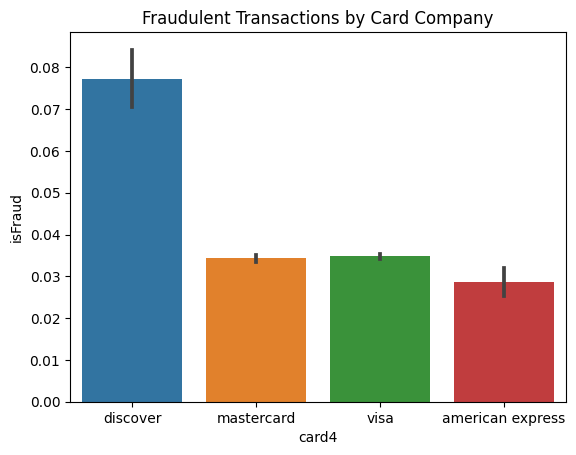

In [34]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

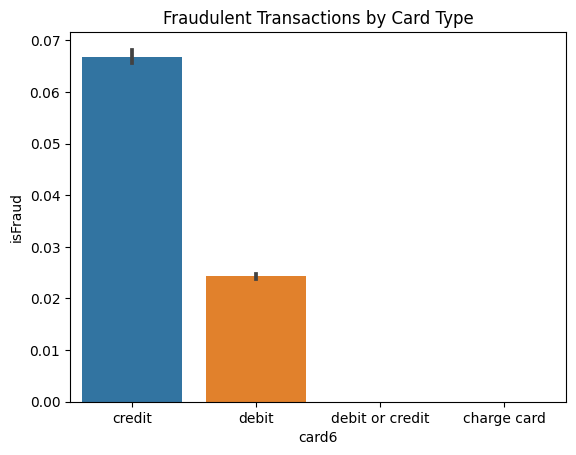

In [35]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

#### Распределение транзакций в разрезе типа устройства

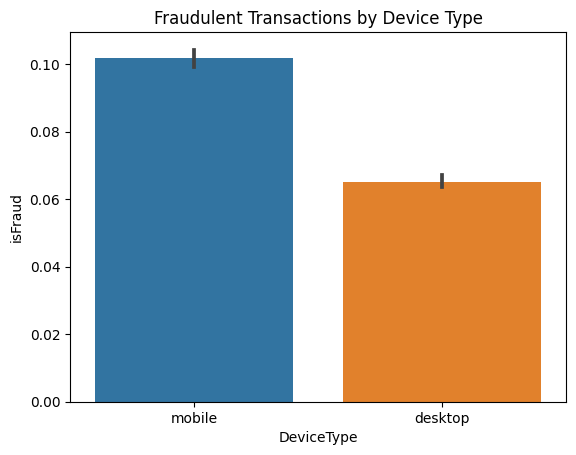

In [36]:
isFraud_by_feature('DeviceType', df=train_df, title='Device Type')

Большинство транзакций было произведено с мобильных устройств

#### Построим гистограмму распределения транзакционных платежей (TransactionAMT)

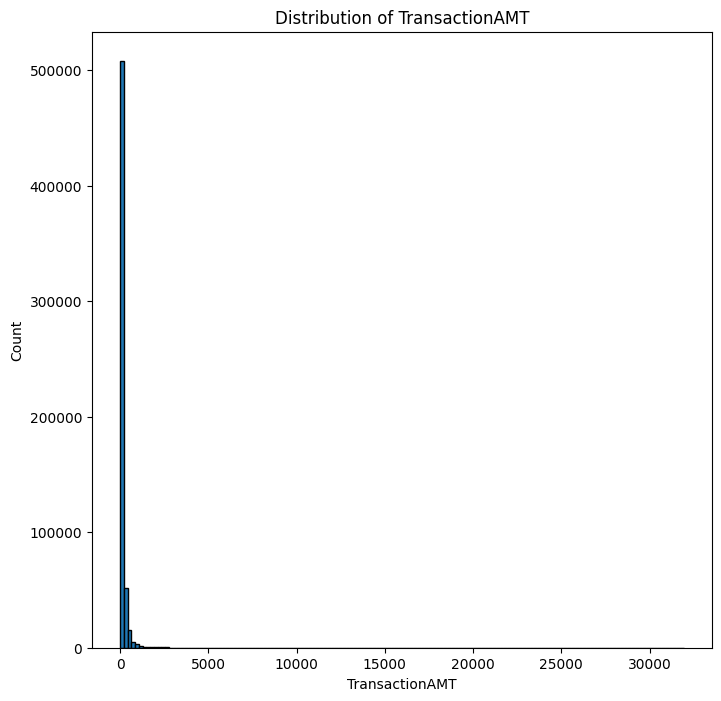

In [37]:
plt.figure(figsize=(8,8))
plt.hist(train_df['TransactionAmt'], bins=150, edgecolor='black')
plt.xlabel('TransactionAMT')
plt.ylabel('Count')
plt.title('Distribution of TransactionAMT')
plt.show()

#### Здесь виден явный выброс в данных

Посмотрим на статистики этого признака

In [38]:
train_df['TransactionAmt'].describe()

count    590540.000000
mean        135.027161
std         239.162521
min           0.251000
25%          43.320999
50%          68.769001
75%         125.000000
max       31937.390625
Name: TransactionAmt, dtype: float64

Посмотрим на топ 10 самых больших значений этого столбца

In [39]:
train_df['TransactionAmt'].dropna().sort_values().tail(10)

315172     5279.950195
462514     5279.950195
584767     5366.819824
275535     5420.000000
275529     5420.000000
384603     5543.229980
248413     6085.229980
296021     6450.970215
274336    31937.390625
274339    31937.390625
Name: TransactionAmt, dtype: float32

Выведем график ```boxplot```, чтобы убедиться, что эти значения похожи на выбросы

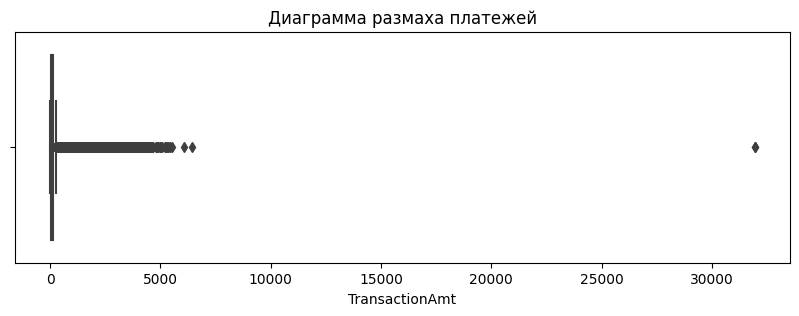

In [40]:
plt.figure(figsize=(10,3))
sns.boxplot(x=train_df['TransactionAmt'])
plt.title('Диаграмма размаха платежей')
plt.xlabel('TransactionAmt')
plt.show()

#### Избавимся от выбросов

Рассчитаем интерквартильный размах

In [41]:
first_quartile = train_df['TransactionAmt'].describe()['25%']
third_quartile = train_df['TransactionAmt'].describe()['75%']

iqr = third_quartile - first_quartile

Отделим данные от выбросов

In [42]:
condition = (train_df['TransactionAmt'] > (first_quartile - 3 * iqr)) & (train_df['TransactionAmt'] < (third_quartile + 3 * iqr))
condition

0         True
1         True
2         True
3         True
4         True
          ... 
590535    True
590536    True
590537    True
590538    True
590539    True
Name: TransactionAmt, Length: 590540, dtype: bool

In [43]:
condition[condition==True].count()

554118

In [44]:
condition[condition==False].count()

36422

Применим созданное условие к нашим данным, отфильтровав строки, не являющиеся выбросами

In [45]:
train_df = train_df[condition]

In [46]:
train_df.shape

(554118, 360)

In [47]:
train_df

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_20,id_28,id_29,id_31,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.500000,W,13926,362.555511,150.0,discover,142.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,2987001,0,86401,29.000000,W,2755,404.000000,150.0,mastercard,102.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,2987002,0,86469,59.000000,W,4663,490.000000,150.0,visa,166.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,2987003,0,86499,50.000000,W,18132,567.000000,150.0,mastercard,117.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,2987004,0,86506,50.000000,H,4497,514.000000,150.0,mastercard,102.0,...,144.000000,New,NotFound,samsung browser 6.2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.000000,W,6550,362.555511,150.0,visa,226.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590536,3577536,0,15811049,39.500000,W,10444,225.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590537,3577537,0,15811079,30.950001,W,12037,595.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1
590538,3577538,0,15811088,117.000000,W,7826,481.000000,150.0,mastercard,224.0,...,403.882568,-1,-1,-1,-1,-1,-1,-1,-1,-1


Построим ещё раз гистограмму распределения поля ```TransactionAmt```

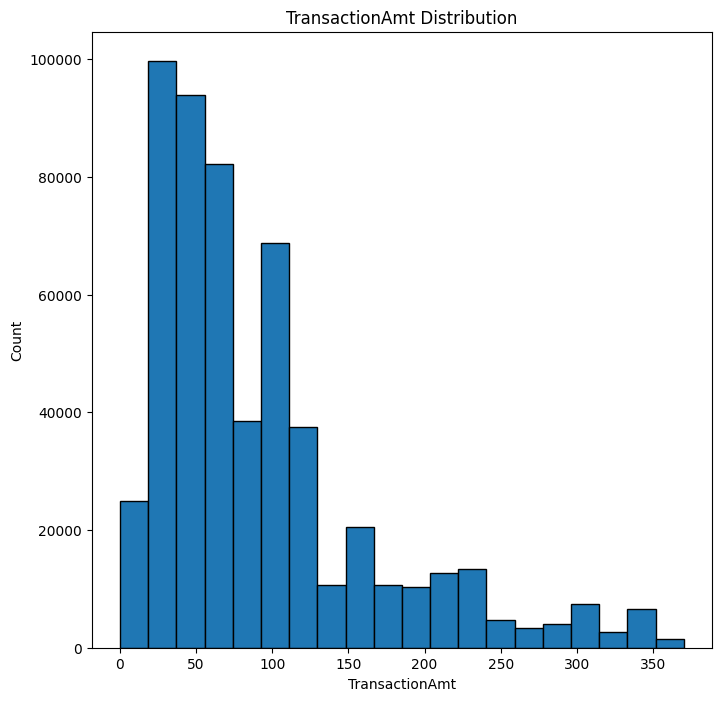

In [48]:
plt.figure(figsize=(8,8))
plt.hist(train_df['TransactionAmt'], bins=20, edgecolor='black')
plt.xlabel('TransactionAmt')
plt.ylabel('Count')
plt.title('TransactionAmt Distribution')
plt.show()

Также ещё раз построим ```boxplot```, чтобы убедиться в отсутствии выбросов

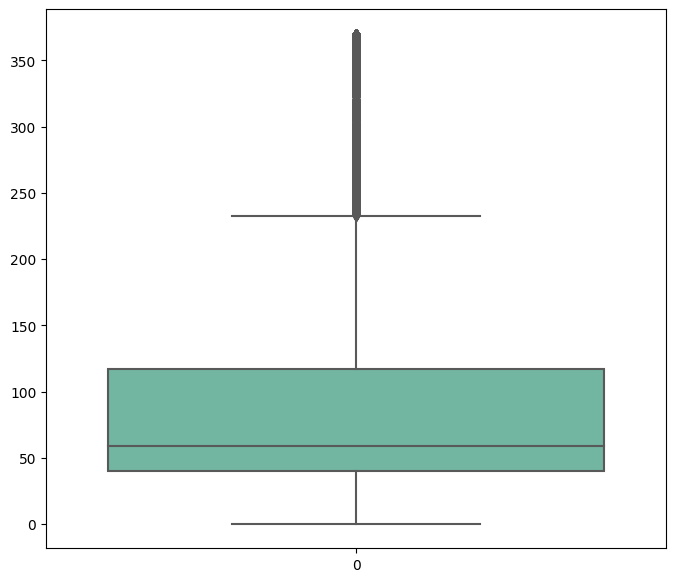

In [49]:
plt.figure(figsize=(8,7))
sns.boxplot(data=train_df['TransactionAmt'].values, palette='Set2')
plt.show()

Посмотрим на распределение ```TransactionAmt``` на тестовом датасете:

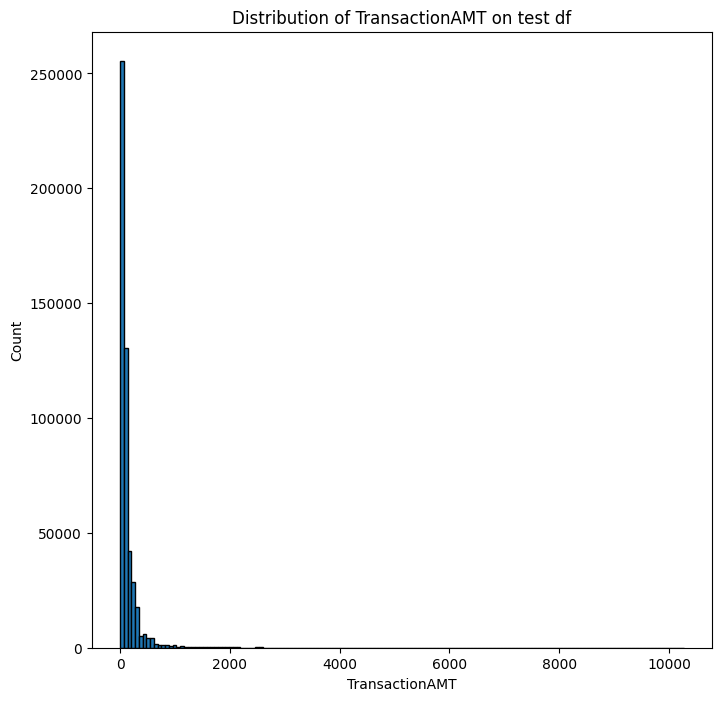

In [50]:
plt.figure(figsize=(8,8))
plt.hist(test_df['TransactionAmt'], bins=150, edgecolor='black')
plt.xlabel('TransactionAMT')
plt.ylabel('Count')
plt.title('Distribution of TransactionAMT on test df')
plt.show()

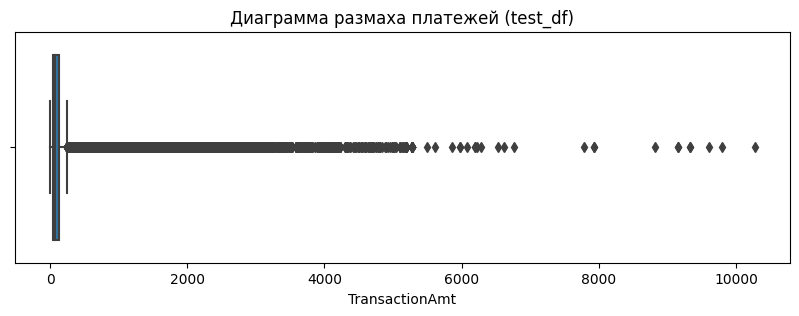

In [51]:
plt.figure(figsize=(10,3))
sns.boxplot(x=test_df['TransactionAmt'])
plt.title('Диаграмма размаха платежей (test_df)')
plt.xlabel('TransactionAmt')
plt.show()

Аналогично очистим тестовый датасет от выбросов признака ```TransactionAMT```

Используя ```Label Encoder``` преорабразуем категориальные признаки в числа

In [52]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        le = LabelEncoder()
        le.fit(list(train_df[f].values))
        train_df[f] = le.transform(list(train_df[f].values))

/tmp/ipykernel_20/3288612165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f] = le.transform(list(train_df[f].values))
/tmp/ipykernel_20/3288612165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f] = le.transform(list(train_df[f].values))
/tmp/ipykernel_20/3288612165.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

Используя ```Label Encoder``` преорабразуем категориальные признаки в числа

In [53]:
for f in test_df.columns:
    if test_df[f].dtype=='object':
        le = LabelEncoder()
        le.fit(list(test_df[f].values))
        test_df[f] = le.transform(list(test_df[f].values))

Посмотрим на объёмы занимаемой памяти после преобразования числовых типов и кодирования типов ```object``` в числовые типы

Напишем функцию для подсчёт изменений памяти:

In [54]:
def memory_changes(start_mem_usage, df, df_name):
    cur_mem_usage = memory_usage(df)
    diff_mem = (start_mem_usage - cur_mem_usage)
    diff_mem_prct = 100-((cur_mem_usage * 100)/start_mem_usage)
    print(f'Memory usage of {df_name} decreased from {start_mem_usage} to {cur_mem_usage} on {diff_mem} Mb ({diff_mem_prct})%')

### ```train_df``` после преобразований

In [55]:
memory_changes(train_df_GB * 1024, df=train_df, df_name='train_df')

Memory usage of train_df decreased from 2567.094612121582 to 817.5092182159424 on 1749.5853939056396 Mb (68.15430119498753)%


### ```test_df``` после преобразований

In [56]:
memory_changes(test_df_GB * 1024, df=test_df, df_name='test_df')

Memory usage of test_df decreased from 2214.031036376953 to 743.1897029876709 on 1470.8413333892822 Mb (66.43273329158797)%


Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [57]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>